
# download packages

In [1]:
!pip install plotly


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Import the libraries

In [2]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

2023-04-27 17:33:31.854566: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 17:33:32.564709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 17:33:34.304460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# prepare train test splits

In [3]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    
    return X_train, X_test, Y_train, Y_test

# Prepare model

In [4]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28,1), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;


# prepare the training plan

In [5]:
def train_model(model, X_train, Y_train, EPOCHS=100):
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                       )
    return history

In [6]:
def train_model_tuned(model, X_train, Y_train, EPOCHS=100):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    #
    return history

# test the model

In [7]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

# training curves plot

In [8]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

# multi class confusion matrix

In [9]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [10]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('../' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [11]:
base_skin_dir = os.path.join('..', 'SkinCancer')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,'*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [12]:
data = pd.read_csv('HAM10000_metadata.csv')

# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [13]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [14]:
data.describe(exclude=[np.number])

lesion_id      image_id     dx dx_type    sex localization
count         10015         10015  10015   10015  10015        10015
unique         7470         10015      7       4      3           15
top     HAM_0003789  ISIC_0027419     nv   histo   male         back
freq              6             1   6705    5340   5406         2192

In [15]:
data.count().isna()

lesion_id       False
image_id        False
dx              False
dx_type         False
age             False
sex             False
localization    False
dtype: bool

# Imputing the Null values and preparing the data

In [16]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [17]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [18]:
data.head()

lesion_id      image_id   dx dx_type  age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo   80  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo   80  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo   80  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo   80  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo   75  male          ear   

                             cell_type                                    path  
0  Benign keratosis-like lesions (bkl)  ../SkinCancer/Images1/ISIC_0027419.jpg  
1  Benign keratosis-like lesions (bkl)  ../SkinCancer/Images1/ISIC_0025030.jpg  
2  Benign keratosis-like lesions (bkl)  ../SkinCancer/Images1/ISIC_0026769.jpg  
3  Benign keratosis-like lesions (bkl)  ../SkinCancer/Images1/ISIC_0025661.jpg  
4  Benign keratosis-like lesions (bkl)  ../SkinCancer/Images2/ISIC_0031633.jpg

In [19]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).convert('L').resize((28,28))))


In [20]:
data['image_pixel'].shape

(10015,)

In [21]:
data.head(5)

lesion_id      image_id   dx dx_type  age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo   80  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo   80  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo   80  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo   80  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo   75  male          ear   

                             cell_type  \
0  Benign keratosis-like lesions (bkl)   
1  Benign keratosis-like lesions (bkl)   
2  Benign keratosis-like lesions (bkl)   
3  Benign keratosis-like lesions (bkl)   
4  Benign keratosis-like lesions (bkl)   

                                     path  \
0  ../SkinCancer/Images1/ISIC_0027419.jpg   
1  ../SkinCancer/Images1/ISIC_0025030.jpg   
2  ../SkinCancer/Images1/ISIC_0026769.jpg   
3  ../SkinCancer/Images1/ISIC_0025661.jpg   
4  ../SkinCancer/Images2/ISIC_0031633.jpg   

                                         image_pixel  
0  [[169, 171, 171, 178, 182, 183, 181, 185, 194,...  
1  [[21, 58, 106, 140, 149, 148, 145, 155, 169, 1...  
2  [[156, 163, 162, 168, 167, 171, 156, 153, 166,...  
3  [[28, 72, 116, 140, 137, 153, 149, 161, 172, 1...  
4  [[130, 162, 181, 196, 205, 208, 206, 214, 225,...

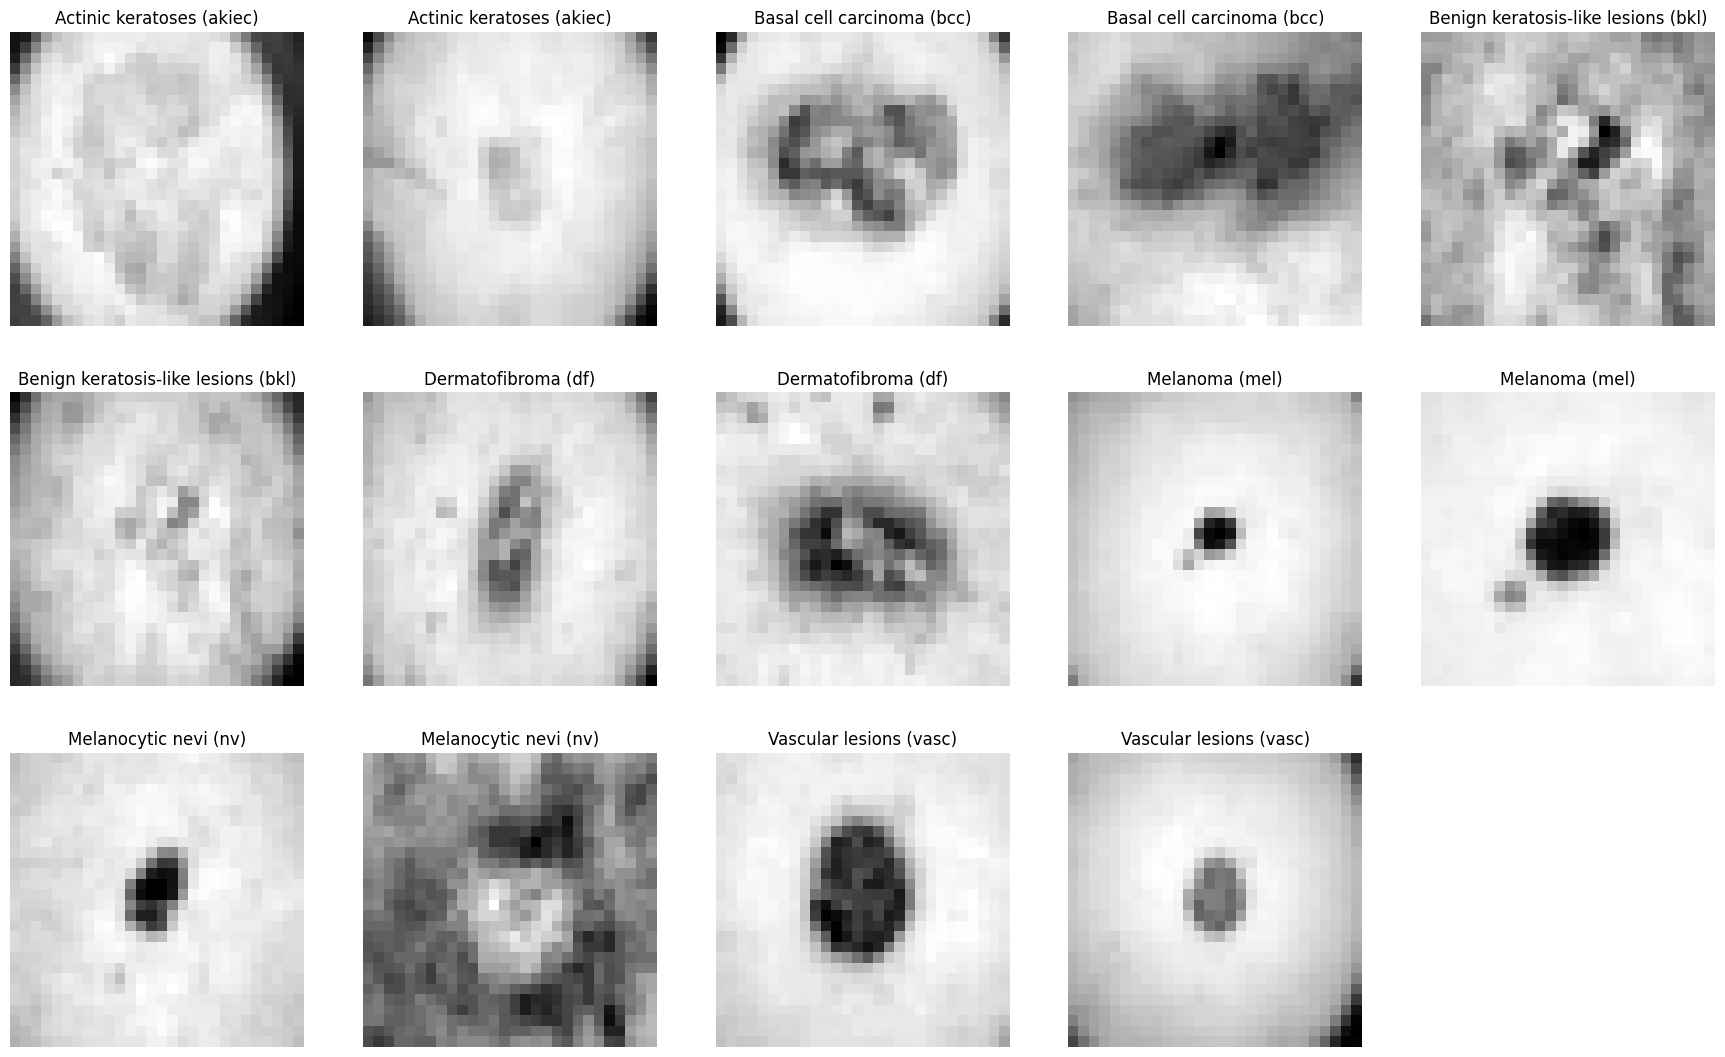

In [22]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i] ),cmap = 'gray')
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [23]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [24]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

/tmp/ipykernel_1348/525713152.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index = df_index.append([df_index]*i, ignore_index = True)


In [25]:
len(frames)

7

In [26]:
final_data = pd.concat(frames)

In [27]:
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)


In [28]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28)
(10015, 1)


In [29]:
final_data['dx'].value_counts()
data['dx'].value_counts()

nv       6705
bcc      6682
mel      6678
vasc     6674
bkl      6594
akiec    6213
df       6210
Name: dx, dtype: int64

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [30]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28)
(45756, 1)


In [29]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    print(X_train.shape)
    print(Y_train.shape)
    
    # Add extra axis to represent single color channel
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=10,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest')
    train_datagen.fit(X_train)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(X_test)
    print(X_train.shape)
    print(Y_train.shape)
    
    return X_train, X_test, Y_train, Y_test


In [30]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

(8012, 28, 28)
(8012, 1)
(8012, 28, 28, 1)
(8012, 1)


In [33]:
model_1 =create_model()
model_2 = create_model()



2023-04-27 06:05:42.921145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

2023-04-27 06:05:42.956175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 06:05:42.959342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 06:05:42.962827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 64)   

In [31]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

NameError: name 'X_aug' is not defined

In [35]:
model1_history = train_model(model_1, X_train_aug, Y_train_aug, 200)
#model1_tuned_history = train_model_tuned(model_1_tuned, X_train_aug, Y_train_aug, 200)

Epoch 1/200


2023-04-27 06:05:46.247971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-04-27 06:05:47.059948: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55d5903d7990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-27 06:05:47.059978: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-04-27 06:05:47.065113: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-27 06:05:47.202788: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


458/458 [==============================] - 7s 5ms/step - loss: 1.7616 - accuracy: 0.3083 - val_loss: 1.5952 - val_accuracy: 0.3658
Epoch 2/200
458/458 [==============================] - 2s 4ms/step - loss: 1.3196 - accuracy: 0.4854 - val_loss: 1.2473 - val_accuracy: 0.4809
Epoch 3/200
458/458 [==============================] - 2s 4ms/step - loss: 0.9347 - accuracy: 0.6447 - val_loss: 0.8921 - val_accuracy: 0.6544
Epoch 4/200
458/458 [==============================] - 2s 4ms/step - loss: 0.6968 - accuracy: 0.7339 - val_loss: 0.5879 - val_accuracy: 0.7728
Epoch 5/200
458/458 [==============================] - 2s 4ms/step - loss: 0.5052 - accuracy: 0.8095 - val_loss: 0.5373 - val_accuracy: 0.8025
Epoch 6/200
458/458 [==============================] - 2s 4ms/step - loss: 0.3995 - accuracy: 0.8506 - val_loss: 0.4417 - val_accuracy: 0.8380
Epoch 7/200
458/458 [==============================] - 2s 4ms/step - loss: 0.3010 - accuracy: 0.8916 - val_loss: 0.3455 - val_accuracy: 0.8790
Epoch 8/200

In [36]:
model2_history = train_model(model_2, X_train_orig, Y_train_orig, 200)
#model2_tuned_history = train_model_tuned(model_2_tuned, X_train_orig, Y_train_orig, 200)

Epoch 1/200
101/101 [==============================] - 3s 8ms/step - loss: 1.5413 - accuracy: 0.6502 - val_loss: 1.1479 - val_accuracy: 0.6550
Epoch 2/200
101/101 [==============================] - 0s 4ms/step - loss: 1.0899 - accuracy: 0.6706 - val_loss: 1.1092 - val_accuracy: 0.6500
Epoch 3/200
101/101 [==============================] - 0s 4ms/step - loss: 1.0452 - accuracy: 0.6770 - val_loss: 1.0376 - val_accuracy: 0.6719
Epoch 4/200
101/101 [==============================] - 0s 4ms/step - loss: 1.0056 - accuracy: 0.6820 - val_loss: 1.0573 - val_accuracy: 0.6625
Epoch 5/200
101/101 [==============================] - 0s 4ms/step - loss: 0.9727 - accuracy: 0.6945 - val_loss: 0.9791 - val_accuracy: 0.6837
Epoch 6/200
101/101 [==============================] - 0s 4ms/step - loss: 0.9460 - accuracy: 0.6925 - val_loss: 0.9770 - val_accuracy: 0.6868
Epoch 7/200
101/101 [==============================] - 0s 4ms/step - loss: 0.9213 - accuracy: 0.6961 - val_loss: 0.9546 - val_accuracy: 0.6875

In [37]:
model_1
model_2

# save model

In [38]:
model_1.save('Skin_Cancer1.sav')
model_2.save('Skin_Cancer2.sav')

INFO:tensorflow:Assets written to: Skin_Cancer1.sav/assets


INFO:tensorflow:Assets written to: Skin_Cancer1.sav/assets


INFO:tensorflow:Assets written to: Skin_Cancer2.sav/assets


INFO:tensorflow:Assets written to: Skin_Cancer2.sav/assets


# save model weights

In [39]:
model1.save_weights("Skin_Cancer.hdf5")

NameError: name 'model1' is not defined

In [ ]:
from IPython.display import FileLink
FileLink('Skin_Cancer.hdf5')

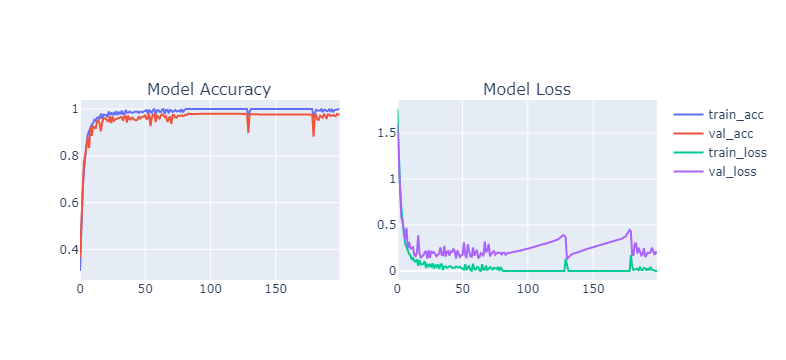

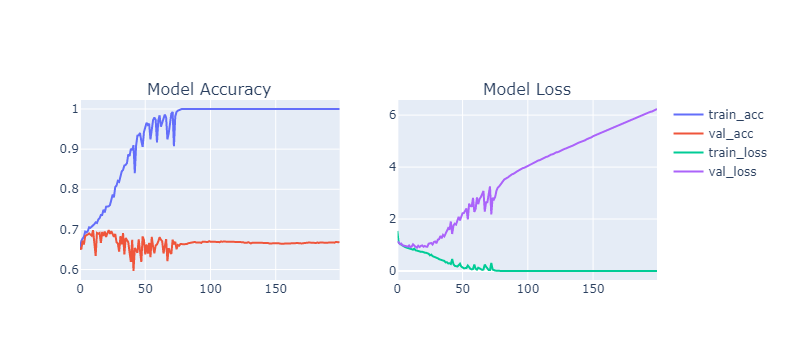

In [40]:
plot_model_training_curve(model1_history)
#plot_model_training_curve(model1_tuned_history)
plot_model_training_curve(model2_history)


#plot_model_training_curve(model2_tuned_history)

Test Accuracy: 97.204%
63/63 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

          nv       1.00      0.96      0.98      1374
         mel       0.88      1.00      0.94       205
         bkl       0.92      1.00      0.96       227
         bcc       0.93      1.00      0.96        94
       akiec       0.98      1.00      0.99        55
        vasc       0.93      1.00      0.97        28
          df       1.00      1.00      1.00        20

    accuracy                           0.97      2003
   macro avg       0.95      0.99      0.97      2003
weighted avg       0.97      0.97      0.97      2003



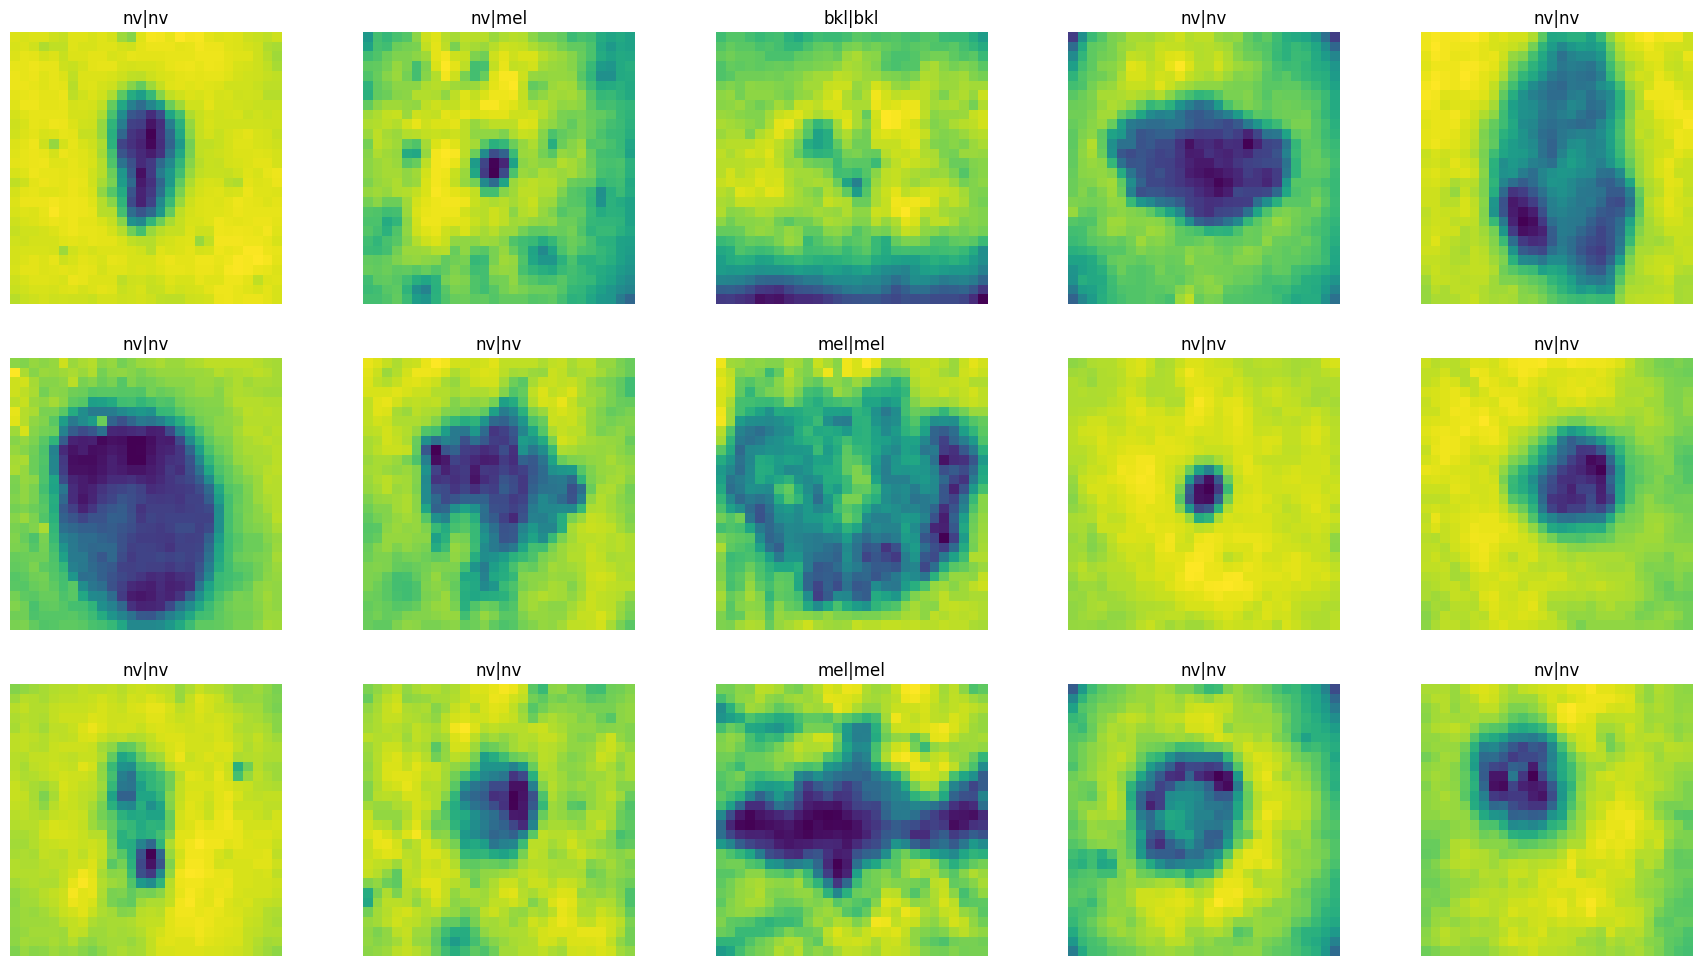

Test Accuracy: 70.594%
63/63 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

          nv       0.82      0.90      0.86      1374
         mel       0.37      0.29      0.33       205
         bkl       0.39      0.29      0.33       227
         bcc       0.30      0.28      0.29        94
       akiec       0.25      0.25      0.25        55
        vasc       0.33      0.07      0.12        28
          df       0.25      0.15      0.19        20

    accuracy                           0.71      2003
   macro avg       0.39      0.32      0.34      2003
weighted avg       0.67      0.71      0.69      2003



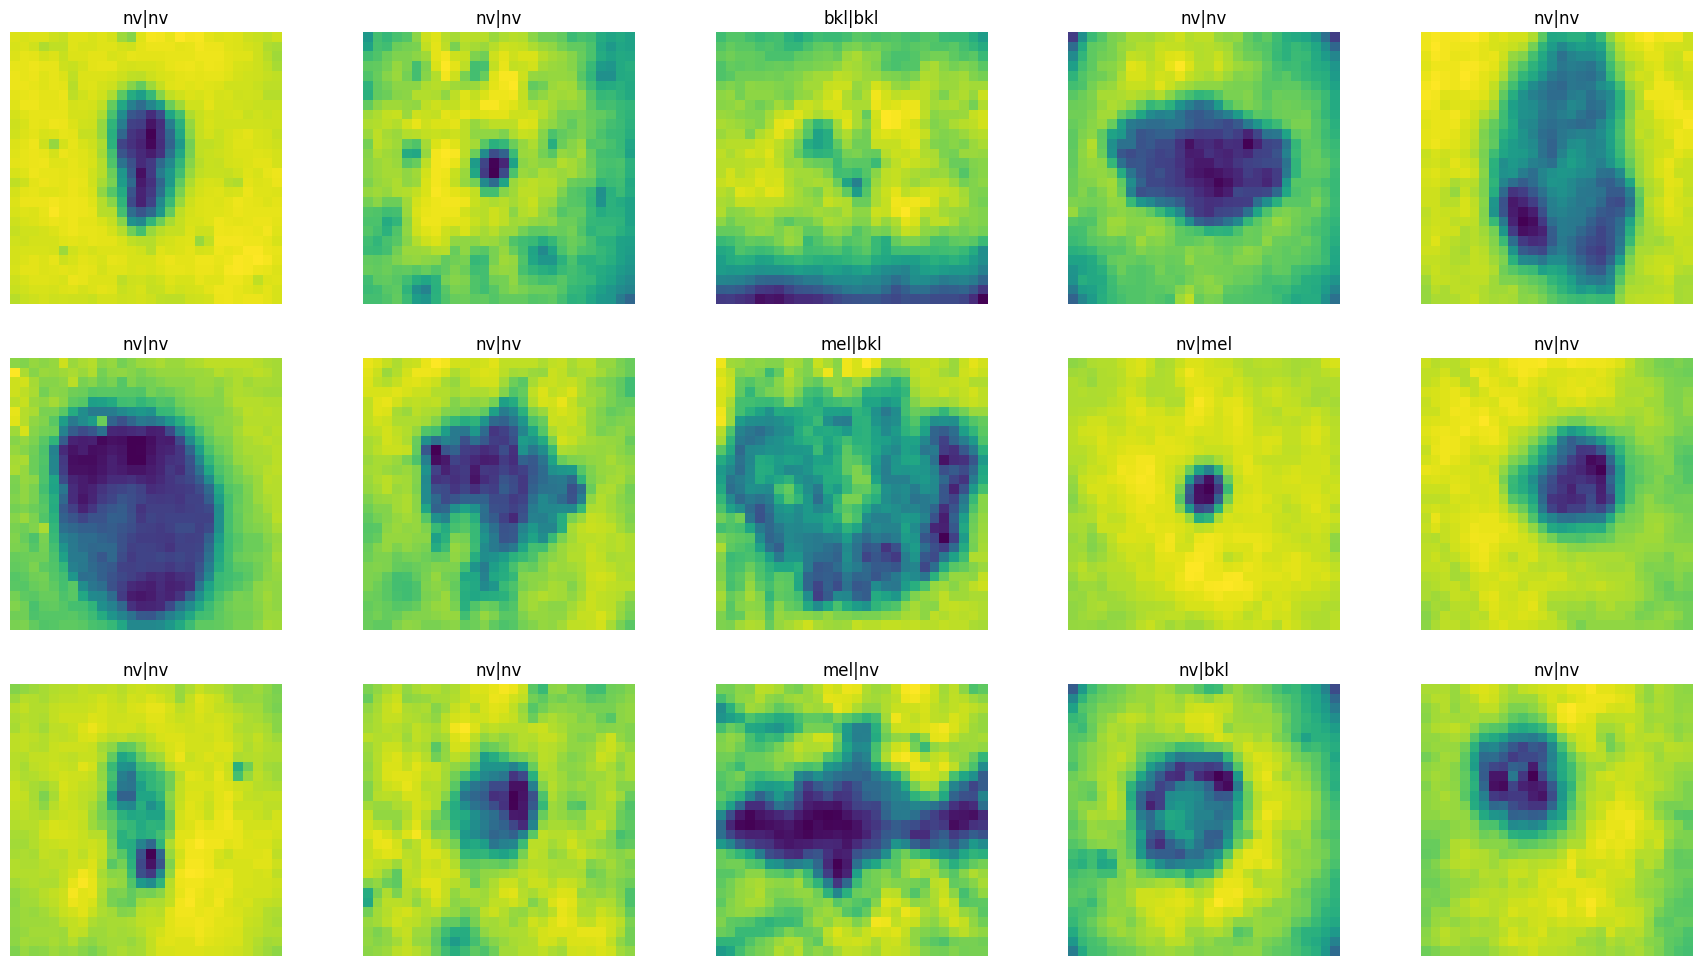

In [41]:
test_model(model_1, X_test_orig, Y_test_orig)
test_model(model_2, X_test_orig, Y_test_orig)
#test_modeli(model_1_tuned, X_test_orig, Y_test_orig)
#test_modeli(model_2_tuned, X_test_orig, Y_test_orig)

# **TESTING ON AUGMENTED TEST DATASET**

Test Accuracy: 97.531%
286/286 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

          nv       0.99      0.85      0.92      1385
         mel       0.93      0.99      0.96      1328
         bkl       0.94      1.00      0.97      1294
         bcc       0.98      1.00      0.99      1325
       akiec       0.99      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.97      9152



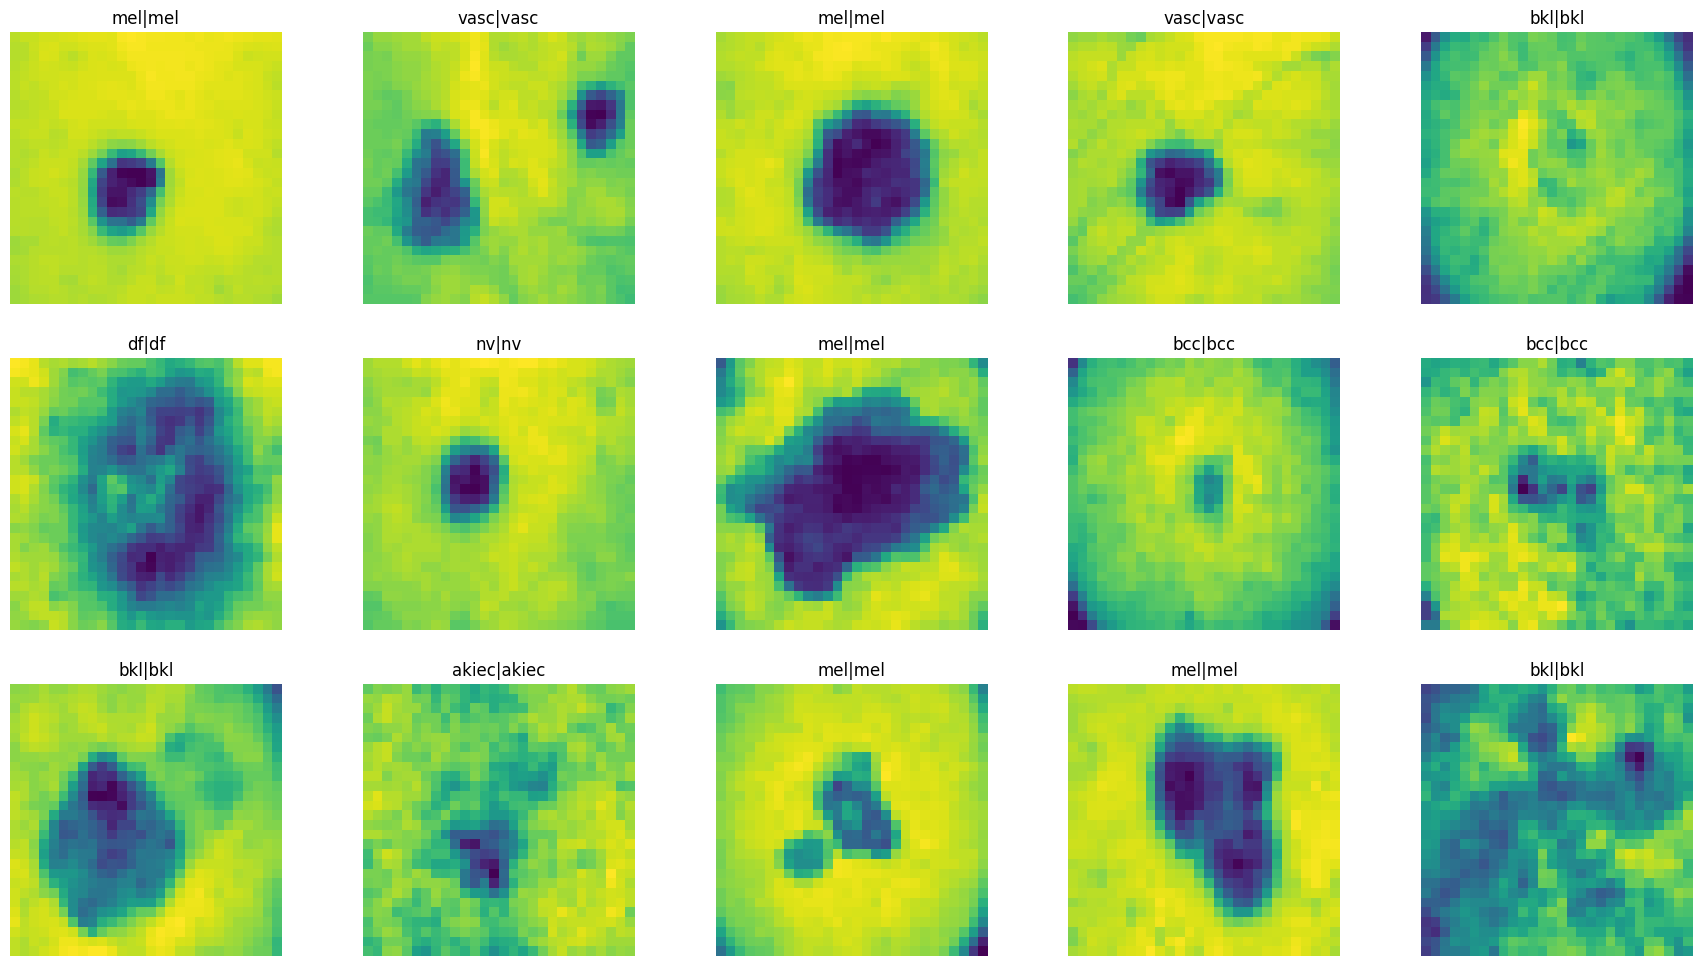

Test Accuracy: 75.339%
286/286 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

          nv       0.52      0.96      0.67      1385
         mel       0.83      0.75      0.79      1328
         bkl       0.68      0.76      0.72      1294
         bcc       0.83      0.72      0.77      1325
       akiec       0.86      0.73      0.79      1270
        vasc       0.99      0.64      0.78      1293
          df       0.99      0.69      0.81      1257

    accuracy                           0.75      9152
   macro avg       0.82      0.75      0.76      9152
weighted avg       0.81      0.75      0.76      9152



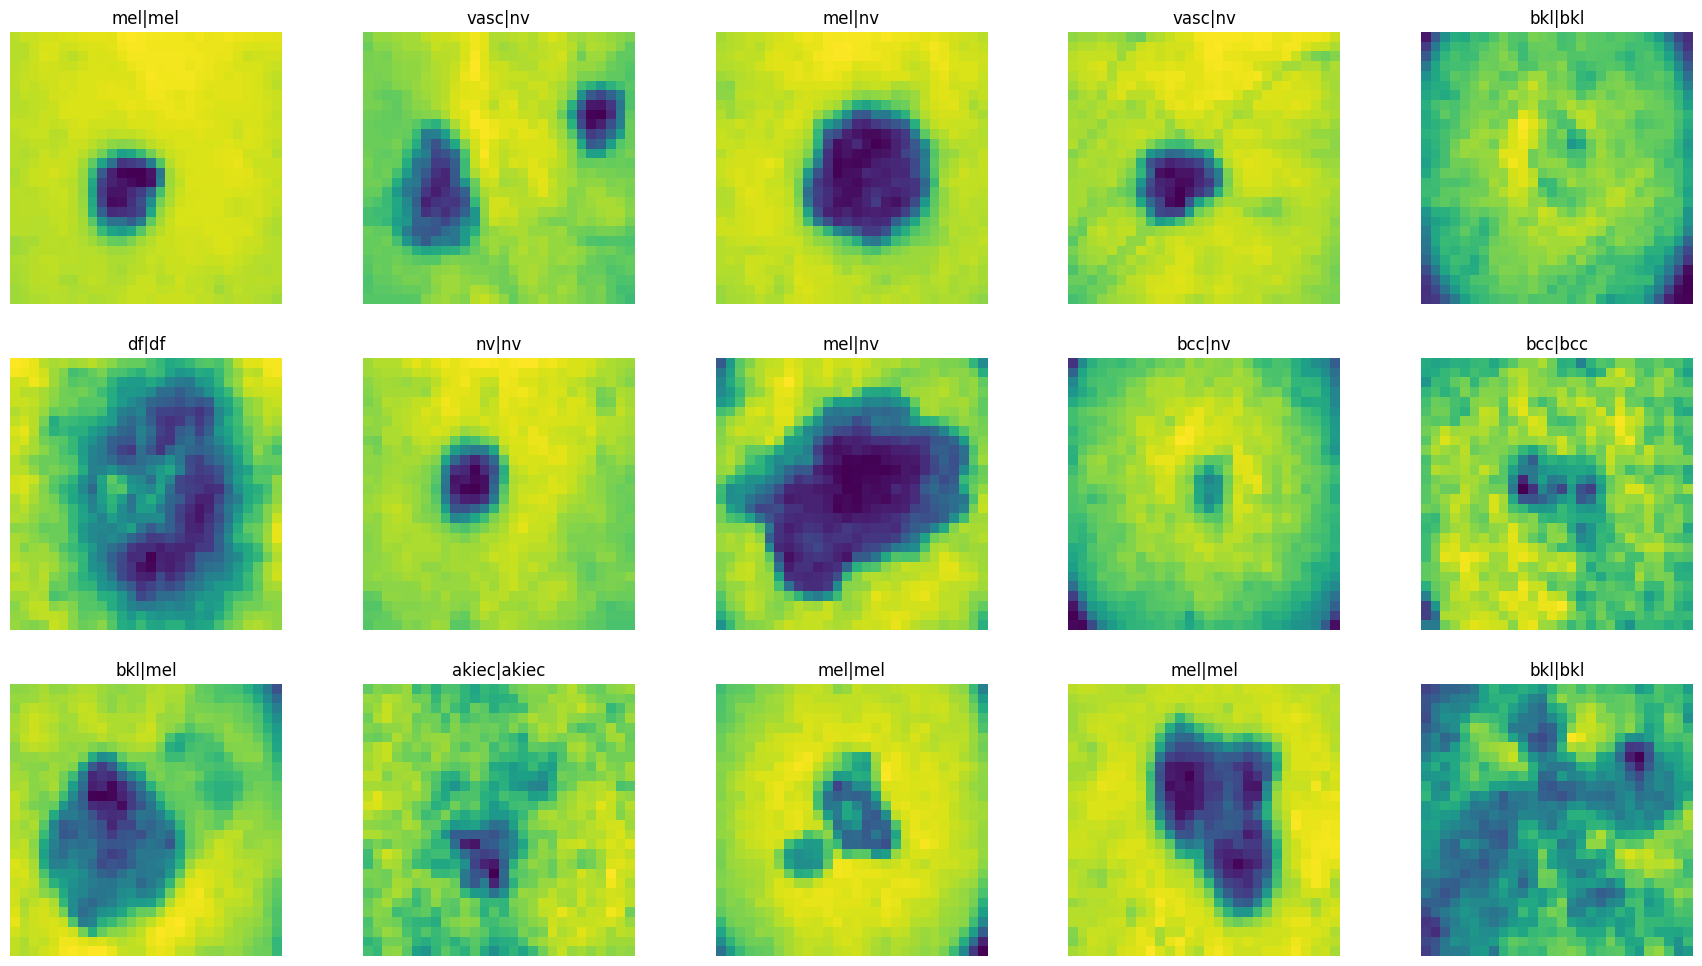

In [42]:
test_model(model_1, X_test_aug, Y_test_aug)
test_model(model_2, X_test_aug, Y_test_aug)

In [43]:
data.head()
data.iloc[2]

index    lesion_id      image_id  dx    dx_type  age     sex  \
0   5007  HAM_0006322  ISIC_0030309  nv  follow_up   55    male   
1   4478  HAM_0003084  ISIC_0026191  nv  follow_up   45  female   
2   4477  HAM_0002093  ISIC_0027032  nv  follow_up   45  female   
3   4476  HAM_0003701  ISIC_0027191  nv  follow_up   45  female   
4   4475  HAM_0003806  ISIC_0028667  nv  follow_up   45  female   

      localization              cell_type  \
0             foot  Melanocytic nevi (nv)   
1  upper extremity  Melanocytic nevi (nv)   
2             back  Melanocytic nevi (nv)   
3  lower extremity  Melanocytic nevi (nv)   
4  lower extremity  Melanocytic nevi (nv)   

                                     path  \
0  ../SkinCancer/Images2/ISIC_0030309.jpg   
1  ../SkinCancer/Images1/ISIC_0026191.jpg   
2  ../SkinCancer/Images1/ISIC_0027032.jpg   
3  ../SkinCancer/Images1/ISIC_0027191.jpg   
4  ../SkinCancer/Images1/ISIC_0028667.jpg   

                                         image_pixel  label  
0  [[184, 184, 187, 188, 190, 188, 188, 186, 190,...      0  
1  [[146, 152, 154, 154, 161, 160, 169, 175, 179,...      0  
2  [[166, 172, 163, 164, 166, 159, 168, 173, 168,...      0  
3  [[153, 156, 156, 159, 161, 162, 164, 164, 163,...      0  
4  [[175, 178, 177, 177, 180, 180, 183, 183, 180,...      0

index                                                        4477
lesion_id                                             HAM_0002093
image_id                                             ISIC_0027032
dx                                                             nv
dx_type                                                 follow_up
age                                                            45
sex                                                        female
localization                                                 back
cell_type                                   Melanocytic nevi (nv)
path                       ../SkinCancer/Images1/ISIC_0027032.jpg
image_pixel     [[166, 172, 163, 164, 166, 159, 168, 173, 168,...
label                                                           0
Name: 2, dtype: object